# Road Game Data Analysis

## Setup

In [9]:
import pandas as pd
import numpy as np
import os
import sqlite3
import math
from constant_values import get_passing_stat_ids, get_rushing_stat_ids, get_receiving_stat_ids, get_general_stat_ids, id_2_col, operation_2_str, year_2_idx
from scipy import stats
from matplotlib import pyplot as plt
import csv
import time
from itertools import chain
import json

In [10]:
# ==== Config =====
CURRENT_DIR = os.path.dirname('.')
PROJECT_ROOT_DIR = os.path.join(CURRENT_DIR, '..', '..')
config = json.load(open(os.path.join(PROJECT_ROOT_DIR, 'config.json'), 'r'))

In [11]:
# ==== Output Files =====
DATA_DIR = os.path.join(PROJECT_ROOT_DIR, 'data')
DATABASE_DIR = config['sql']['db_dir']
DATABASE_FILENAME = config['sql']['db_name']
DATABASE_PATH = os.path.join(DATABASE_DIR, DATABASE_FILENAME)
conn = sqlite3.connect(DATABASE_PATH)
print('OPENED CONNECTION')

OPENED CONNECTION


In [52]:
# ==== Constants =====
STAT_KEYS = ['home_mean', 'road_mean', 'home_std', 'road_std', 'home_count', 'road_count', 'z_score', 'p_val', 'difference', 'pct_difference', 'stat_type']
general_lower_ids = get_general_stat_ids()
lower_id_2_sql = id_2_col()
PASSING_STAT_COLS = [lower_id_2_sql[p] for p in get_passing_stat_ids()]
RUSHING_STAT_COLS = [lower_id_2_sql[r] for r in get_rushing_stat_ids()]
RECEIVING_STAT_COLS = [lower_id_2_sql[r] for r in get_receiving_stat_ids()]
OP_2_STR = operation_2_str()

## Process Results Functions

In [53]:
# ==== SQL Statemnt Formatter =====
def get_kvd_value(val):
    """
    params:
        - val (int OR float OR str): Value in Key-Value dictionary for SQL Statement
    returns:
        - val (str): String version of value
    """
    if isinstance(val, str):
        return "'" + str(val) + "'"
    return str(val)

def format_sql_where(key_value_dict):
    """
    params:
        - key_value_dict (dict): SQL WHERE statement in input format
    returns:
        - statement (str): SQL formatted WHERE statement
    """
    statement_list = ['{0} {1} {2}'.format(k, key_value_dict[k]['operation'], get_kvd_value(key_value_dict[k]['value'])) for k in key_value_dict]
    statement = ' AND '.join(statement_list)
    return statement

def get_sql_statement(key_value_dict, data_type):
    """
    params:
        - key_value_dict (dict): SQL statement in input format
        - data_type (str): The table we are querying (passing, rushing, receiving)
    returns:
        - statement (str): SQL formatted statement
    """
    table = 'passing_statistics'
    if data_type == 'rushing':
        table = 'rushing_statistics'
    elif data_type == 'receiving':
        table = 'receiving_statistics'

    statement = '''SELECT * FROM %s''' % table
    if len(key_value_dict) > 0:
        statement += ' WHERE ' + format_sql_where(key_value_dict)

    return statement + ';'

In [54]:
# ==== Load Games From SQL
def get_road_games(key_value_dict, data_type):
    """
    params:
        - key_value_dict (dict): SQL statement in input format
        - data_type (str): The table we are querying (passing, rushing, receiving)
    returns:
        - road_games (pandas DataFrame): Results of SQL query for road games
    """
    key_value_dict['GAME_LOCATION'] = {
        'value': '@',
        'operation': '='
    }

    statement = get_sql_statement(key_value_dict, data_type)
    road_games = pd.read_sql_query(statement, conn)
    return road_games

def get_home_games(key_value_dict, data_type):
    """
    params:
        - key_value_dict (dict): SQL statement in input format
        - data_type (str): The table we are querying (passing, rushing, receiving)
    returns:
        - home_games (pandas DataFrame): Results of SQL query for road games
    """
    key_value_dict['GAME_LOCATION'] = {
        'value': '',
        'operation': '='
    }
    statement = get_sql_statement(key_value_dict, data_type)
    home_games = pd.read_sql_query(statement, conn)
    return home_games

In [56]:
# ==== Statistic Helper Functions =====
def mapPctToDec(games_stat):
    """
    params:
        - games_stat (pandas Series): List of stat values
    returns:
        - mapped_games (pandas Series): Percent-formatted list of stat values
    """
    mapped_games = []
    for g in games_stat:
        mapped_games.append(float(g.replace('%', ''))/100.0)
    return pd.Series(mapped_games)

def get_z_stats(home_games_stat, road_games_stat):
    """
    params:
        - home_games_stat (pandas Series): List of home values
        - road_games_stat (pandas Series): List of road values
        - stat_id (str): Type of stat you're looking at (unnecessary)???
    returns:
        - t_stat (float): T-statistic from numpy
        - p_val (float): P-value of differences between home/road games
        - cohen (float): Cohen's d between home and road games
        - my_t (float): Manual calculation of t-statistic from other values
    """
    home_mean = np.mean(home_games_stat)
    road_mean = np.mean(road_games_stat)
    home_std = np.std(home_games_stat)
    road_std = np.std(road_games_stat)
    pooled_std = math.sqrt(home_std**2/len(home_games_stat) + road_std**2/len(road_games_stat))
    z_score = (home_mean - road_mean)/pooled_std
    # 2-tailed test, since not making any assumptions about directionality
    p_val = (1-stats.norm.cdf(abs(z_score)))*2
    return z_score, p_val

In [57]:
# ==== Wrapper Function To Get Stats Given Games =====
def get_stats(home_games_stat, road_games_stat, stat_id):
    """
    params:
        - home_games_stat (pandas Series): List of home values
        - road_games_stat (pandas Series): List of road values
        - stat_id (str): Type of stat you're looking at
    returns:
        - stat_dict (dict): A dictionary of stat values
    """
    if stat_id in PASSING_STAT_COLS:
        stat_type = 'passing'
    elif stat_id in RUSHING_STAT_COLS:
        stat_type = 'rushing'
    elif stat_id in RECEIVING_STAT_COLS:
        stat_type = 'receiving'
    else:
        raise Exception('Invalid Stat: ' + stat_id)
        
    if type(home_games_stat[0]) == str:
        if '%' not in home_games_stat[0]:
            raise Exception('Stat is not numeric')
        else:
            home_games_stat = mapPctToDec(home_games_stat)
            road_games_stat = mapPctToDec(road_games_stat)

    z_score, pval = get_z_stats(home_games_stat, road_games_stat)

    home_mean = np.mean(home_games_stat)
    road_mean = np.mean(road_games_stat)

    return {
    'home_mean': home_mean,
    'road_mean': road_mean,
    'home_std': np.std(home_games_stat),
    'road_std': np.std(road_games_stat),
    'home_count': len(home_games_stat),
    'road_count': len(road_games_stat),
    'z_score': z_score,
    'p_val': pval,
    'difference': home_mean - road_mean,
    'pct_difference': (max([home_mean, road_mean]) - min([home_mean, road_mean]))/min([home_mean, road_mean]),
    'stat_type': stat_type
    }

def get_stat_dict(home_games, road_games, stat_col_list):
    """
    params:
        - home_games (pandas DataFrame): All home stat values specified
        - road_games (pandas DataFrame): All road stat values specified
        - stat_id (str): List of stat_ids (SQL format)
    returns:
        - stat_dict (dict): A dictionary of stat values for every statistic
    """
    stat_dict = {}
    for s_id in stat_col_list:
        hg_stats = home_games[s_id]
        rg_stats = road_games[s_id]
        stat_dict[s_id] = get_stats(hg_stats, rg_stats, s_id)
    return stat_dict

## Get Results Functions

In [78]:
# ==== Organize Inputs =====
def get_key_value_dict(data_type):
    """
    params:
        - data_type (str): The type of data we're looking at (passing, rushing, receiving)
    returns:
        - l (dict): A dictionary giving all information required for SQL query
    """
    if data_type == 'receiving':
        l = {
                'YEAR': {
                    'value': 2008,
                    'operation': '>='
                },
                'PLAYOFFS': {
                    'value': 0,
                    'operation': '='
                }
            }
    elif data_type == 'passing':
        l = {
                'YEAR': {
                    'value': 2008,
                    'operation': '>='
                },
                'PASS_ATTEMPTS': {
                    'value': 10,
                    'operation': '>='
                },
                'PLAYOFFS': {
                    'value': 0,
                    'operation': '='
                }
            }
    elif data_type == 'rushing':
        l = {
                'YEAR': {
                    'value': 2008,
                    'operation': '>='
                },
                'RUSH_ATTEMPTS': {
                    'value': 5,
                    'operation': '>='
                },
                'PLAYOFFS': {
                    'value': 0,
                    'operation': '='
                }
            }
    else:
        raise Excpetion('Bad DATA_TYPE')
    return l

In [79]:
# ==== Format Output =====
def get_filename(key_value_dict, data_type):
    """
    parmas:
        - key_value_dict (dict): A dict with all SQL query info
        - data_type (str): The type of statistics being examined
    returns:
        - filename (str): The filename of the output stat CSV
    """
    type_file_dir = os.path.join(DATA_DIR, 'interim', data_type)
    filename = data_type + '_'
    for key in key_value_dict:
        filename += key + '_'
        filename += OP_2_STR[key_value_dict[key]['operation']] + '_' + str(key_value_dict[key]['value']) + '_'
    return os.path.join(type_file_dir, filename[:-1] + '.csv')

In [80]:
def get_stat_ids(data_type):
    """
    params:
        - data_type (str): The type of statistics being examined
    returns:
        - lower_ids (list of str): A list of stat IDs in SQL format
    """
    if data_type == 'passing':
        return PASSING_STAT_COLS
    elif data_type == 'rushing':
        return RUSHING_STAT_COLS
    elif data_type == 'receiving':
        return RECEIVING_STAT_COLS
    raise Exception('Data Type Incorrect')
    return None

In [81]:
# ==== Write Results =====
def write_query_info_to_csv(csv_writer, key_value_dict):
    """
    params:
        - csv_writer (csv writer object): CSV writer
        - key_value_dict (dict): Dict of SQL query info
    returns:
        NONE (writes to file)
    """
    for k in key_value_dict:
        csv_writer.writerow([k, key_value_dict[k]['operation'], key_value_dict[k]['value']])
    header_row = ['stat_id']
    header_row.extend(STAT_KEYS)
    csv_writer.writerow([])
    csv_writer.writerow(header_row)
    
def write_stat_to_csv(stat_vals, stat_id, csv_writer):
    """
    params:
        - stat_vals (list): All stat values for an individual row
        - stat_id (str): The statistic being looked at
        - csv_writer (csv writer object): CSV writer
    returns:
        NONE (writes to file)
    """
    stat_row = [stat_vals[key] for key in STAT_KEYS]
    stat_row.insert(0, stat_id)
    csv_writer.writerow(stat_row)
    
def write_all_aggregated_stats(automatically_overwrite=True):
    """
    params:
        automatically_overwrite (bool): To overwrite existing file or not
    returns:
        NONE (writes to file)
    """
    for dt in ['passing', 'rushing', 'receiving']:
        kvd = get_key_value_dict(dt)
        output_file = get_filename(kvd, dt)
        if os.path.isfile(output_file) and not automatically_overwrite:
            raise Exception('File already exists')
        road_qb_games = get_road_games(kvd.copy(), dt)
        home_games = get_home_games(kvd.copy(), dt)
        csv_file = open(output_file, 'w')
        csv_writer = csv.writer(csv_file)
        write_query_info_to_csv(csv_writer, kvd.copy())
        stat_id_list = get_stat_ids(dt)
        stat_dict = get_stat_dict(home_games, road_qb_games, stat_id_list)
        for stat_id in stat_dict:
            write_stat_to_csv(stat_dict[stat_id], stat_id, csv_writer)

        csv_writer.writerow([])
        csv_writer.writerow([])
        csv_file.close()

In [82]:
# ==== Plotting Statistic Helpers
def get_bins(home_games, road_games, col, num_bins=20):
    """
    params:
        - home_games (pandas Series): List of home game values
        - road_games (pandas Series): List of road game values
        - col (str): Column being examined (unnecessary)???
        - num_bins (int): Number of bins in histogram
    returns:
        - bins (numpy array): Bin values for histogram
    """
    min_val = min(min(home_games.unique()), min(road_games.unique()))
    max_val = max(max(home_games.unique()), max(road_games.unique()))
    if len(home_games.unique()) < num_bins or len(road_games.unique()) < num_bins:
        return range(int(min_val), int(max_val))
    bins = np.linspace(0, max_val, num=num_bins)
    return bins

def get_hist_text(final_stats):
    """
    params:
        - final_stats (dict): Processed stat values
    returns:
        - s (str): Text to display on histogram plot
    """
    s = 'Home Mean: ' + '{0:.3f}'.format(final_stats['home_mean']) + ' (n=' + str(final_stats['home_count']) + ')\n'
    s += 'Road Mean: ' + '{0:.3f}'.format(final_stats['road_mean']) + ' (n=' + str(final_stats['road_count']) + ')\n'
    s += '% Diff: ' + '{0:.3f}'.format(final_stats['difference']*100) + '%\n'
    s += 'z-score: ' + '{0:.3f}'.format(final_stats['z_score']) + '\n'
    s += 'P Val: ' + '{0:.5f}'.format(final_stats['p_val']) + '\n'
    return s

def mod_games(game_stats):
    """
    params:
        - game_stats (pandas Series): Stat values for individual statistics
    returns:
        - game_stats (pandas Series): Modified stat values for individual statistics
    """
    if type(game_stats[0]) == str:
        if '%' not in game_stats[0]:
            raise Exception('Stat is not numeric')
        else:
            return mapPctToDec(game_stats)
    return game_stats

In [83]:
# ==== Plot All Stats =====
def plot_stats(home_games, road_games, data_type):
    """
    params:
        - home_games (pandas DataFrame): All home game stat values
        - road_games (pandas DataFrame): All road game stat values
        - data_type (str): Type of data being looked at (passing, rushing, receiving)
    returns:
        NONE (creates pyplot plots)
    """
    stat_id_list = get_stat_ids(data_type)
    stat_dict = get_stat_dict(home_games, road_games, stat_id_list)
    fig, axs = plt.subplots(nrows=math.ceil(len(stat_id_list)/2), ncols=2)
    fig.set_size_inches(30, 60)
    home_hist_vals = {}
    road_hist_vals = {}
    for col, ax in zip(stat_dict.keys(), chain(*axs)):
        home_games_mod = mod_games(home_games[col])
        road_games_mod = mod_games(road_games[col])
        bins = get_bins(home_games_mod, road_games_mod, col)
        home_n, home_bins, home_patches = ax.hist(home_games_mod, label='Home', alpha=0.5, bins=bins)
        road_n, road_bins, road_patches = ax.hist(road_games_mod, label='Road', alpha=0.5, bins=bins)
        home_hist_vals[col] = { 'n': home_n, 'bins': home_bins, 'patches': home_patches }
        road_hist_vals[col] = { 'n': road_n, 'bins': road_bins, 'patches': road_patches }
        ax.legend(loc='upper right')
        ax.text(0.05, 0.95, get_hist_text(stat_dict[col]), transform=ax.transAxes, fontsize=14,
            verticalalignment='top')
        ax.set_title(col)

In [84]:
OVERALL_STAT_DICT = {}

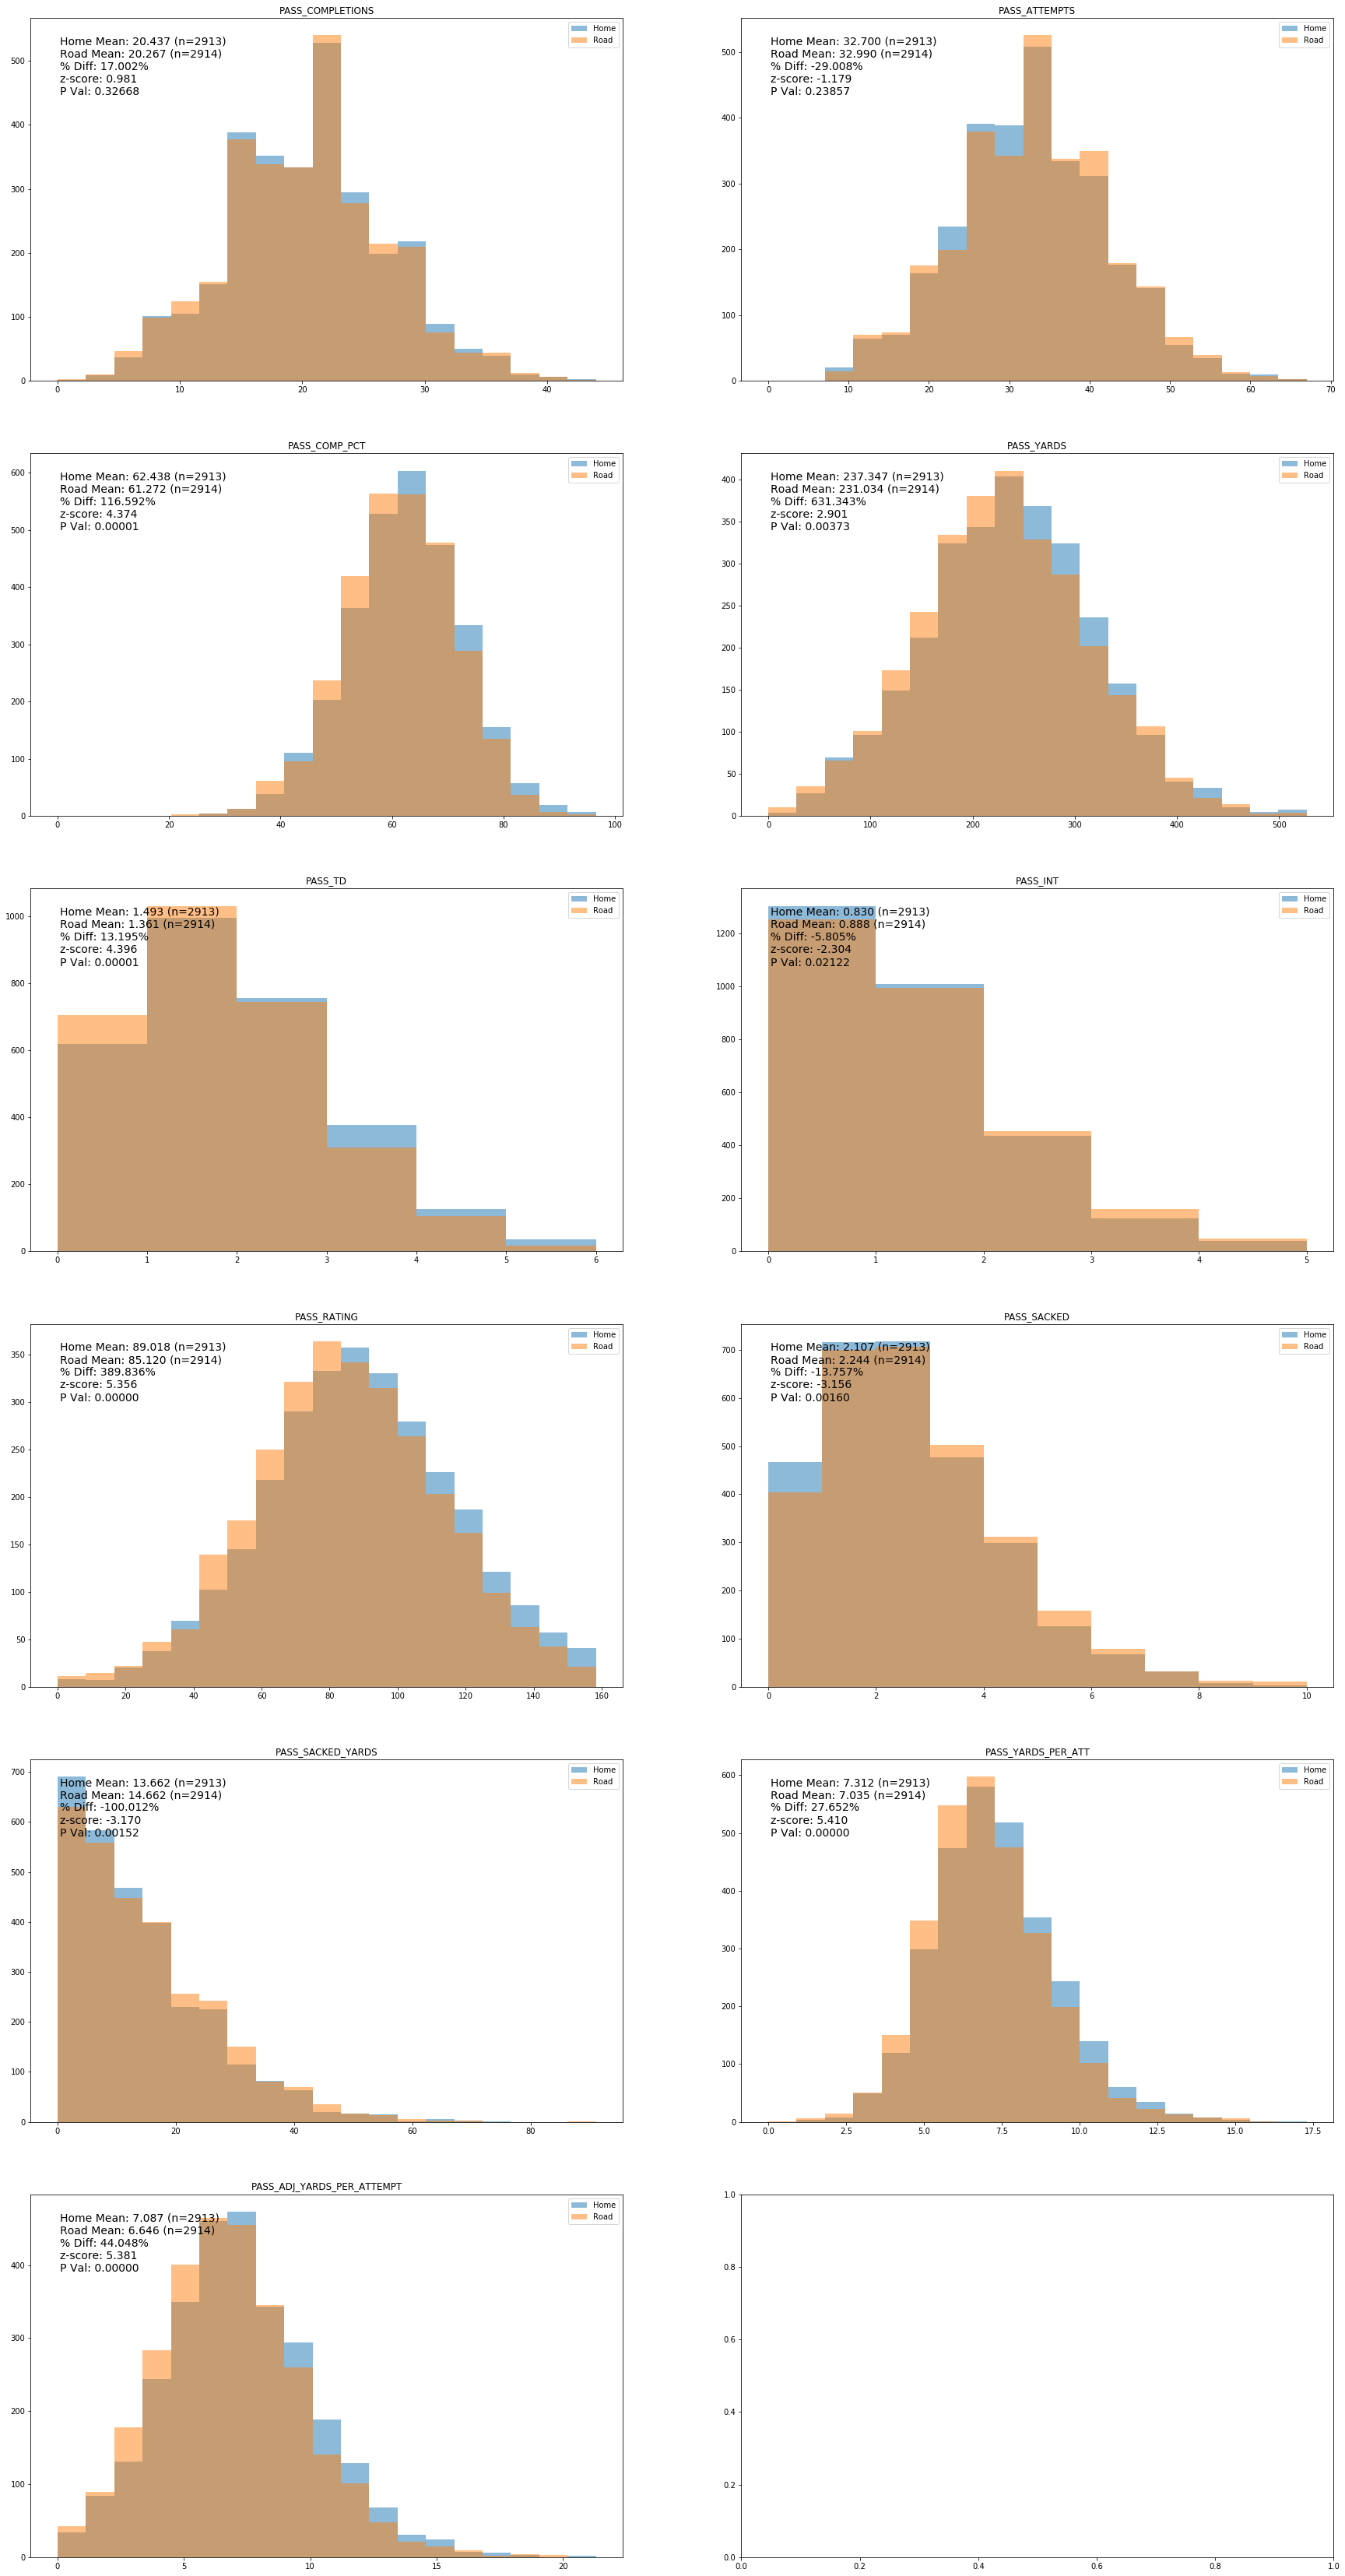

In [85]:
dt = 'passing'
kvd = get_key_value_dict(dt)
hg = get_home_games(kvd.copy(), dt)
rg = get_road_games(kvd.copy(), dt)
passing_stat_dict = get_stat_dict(hg, rg, get_stat_ids(dt))
OVERALL_STAT_DICT.update(stat_dict)
plot_stats(hg, rg, dt)

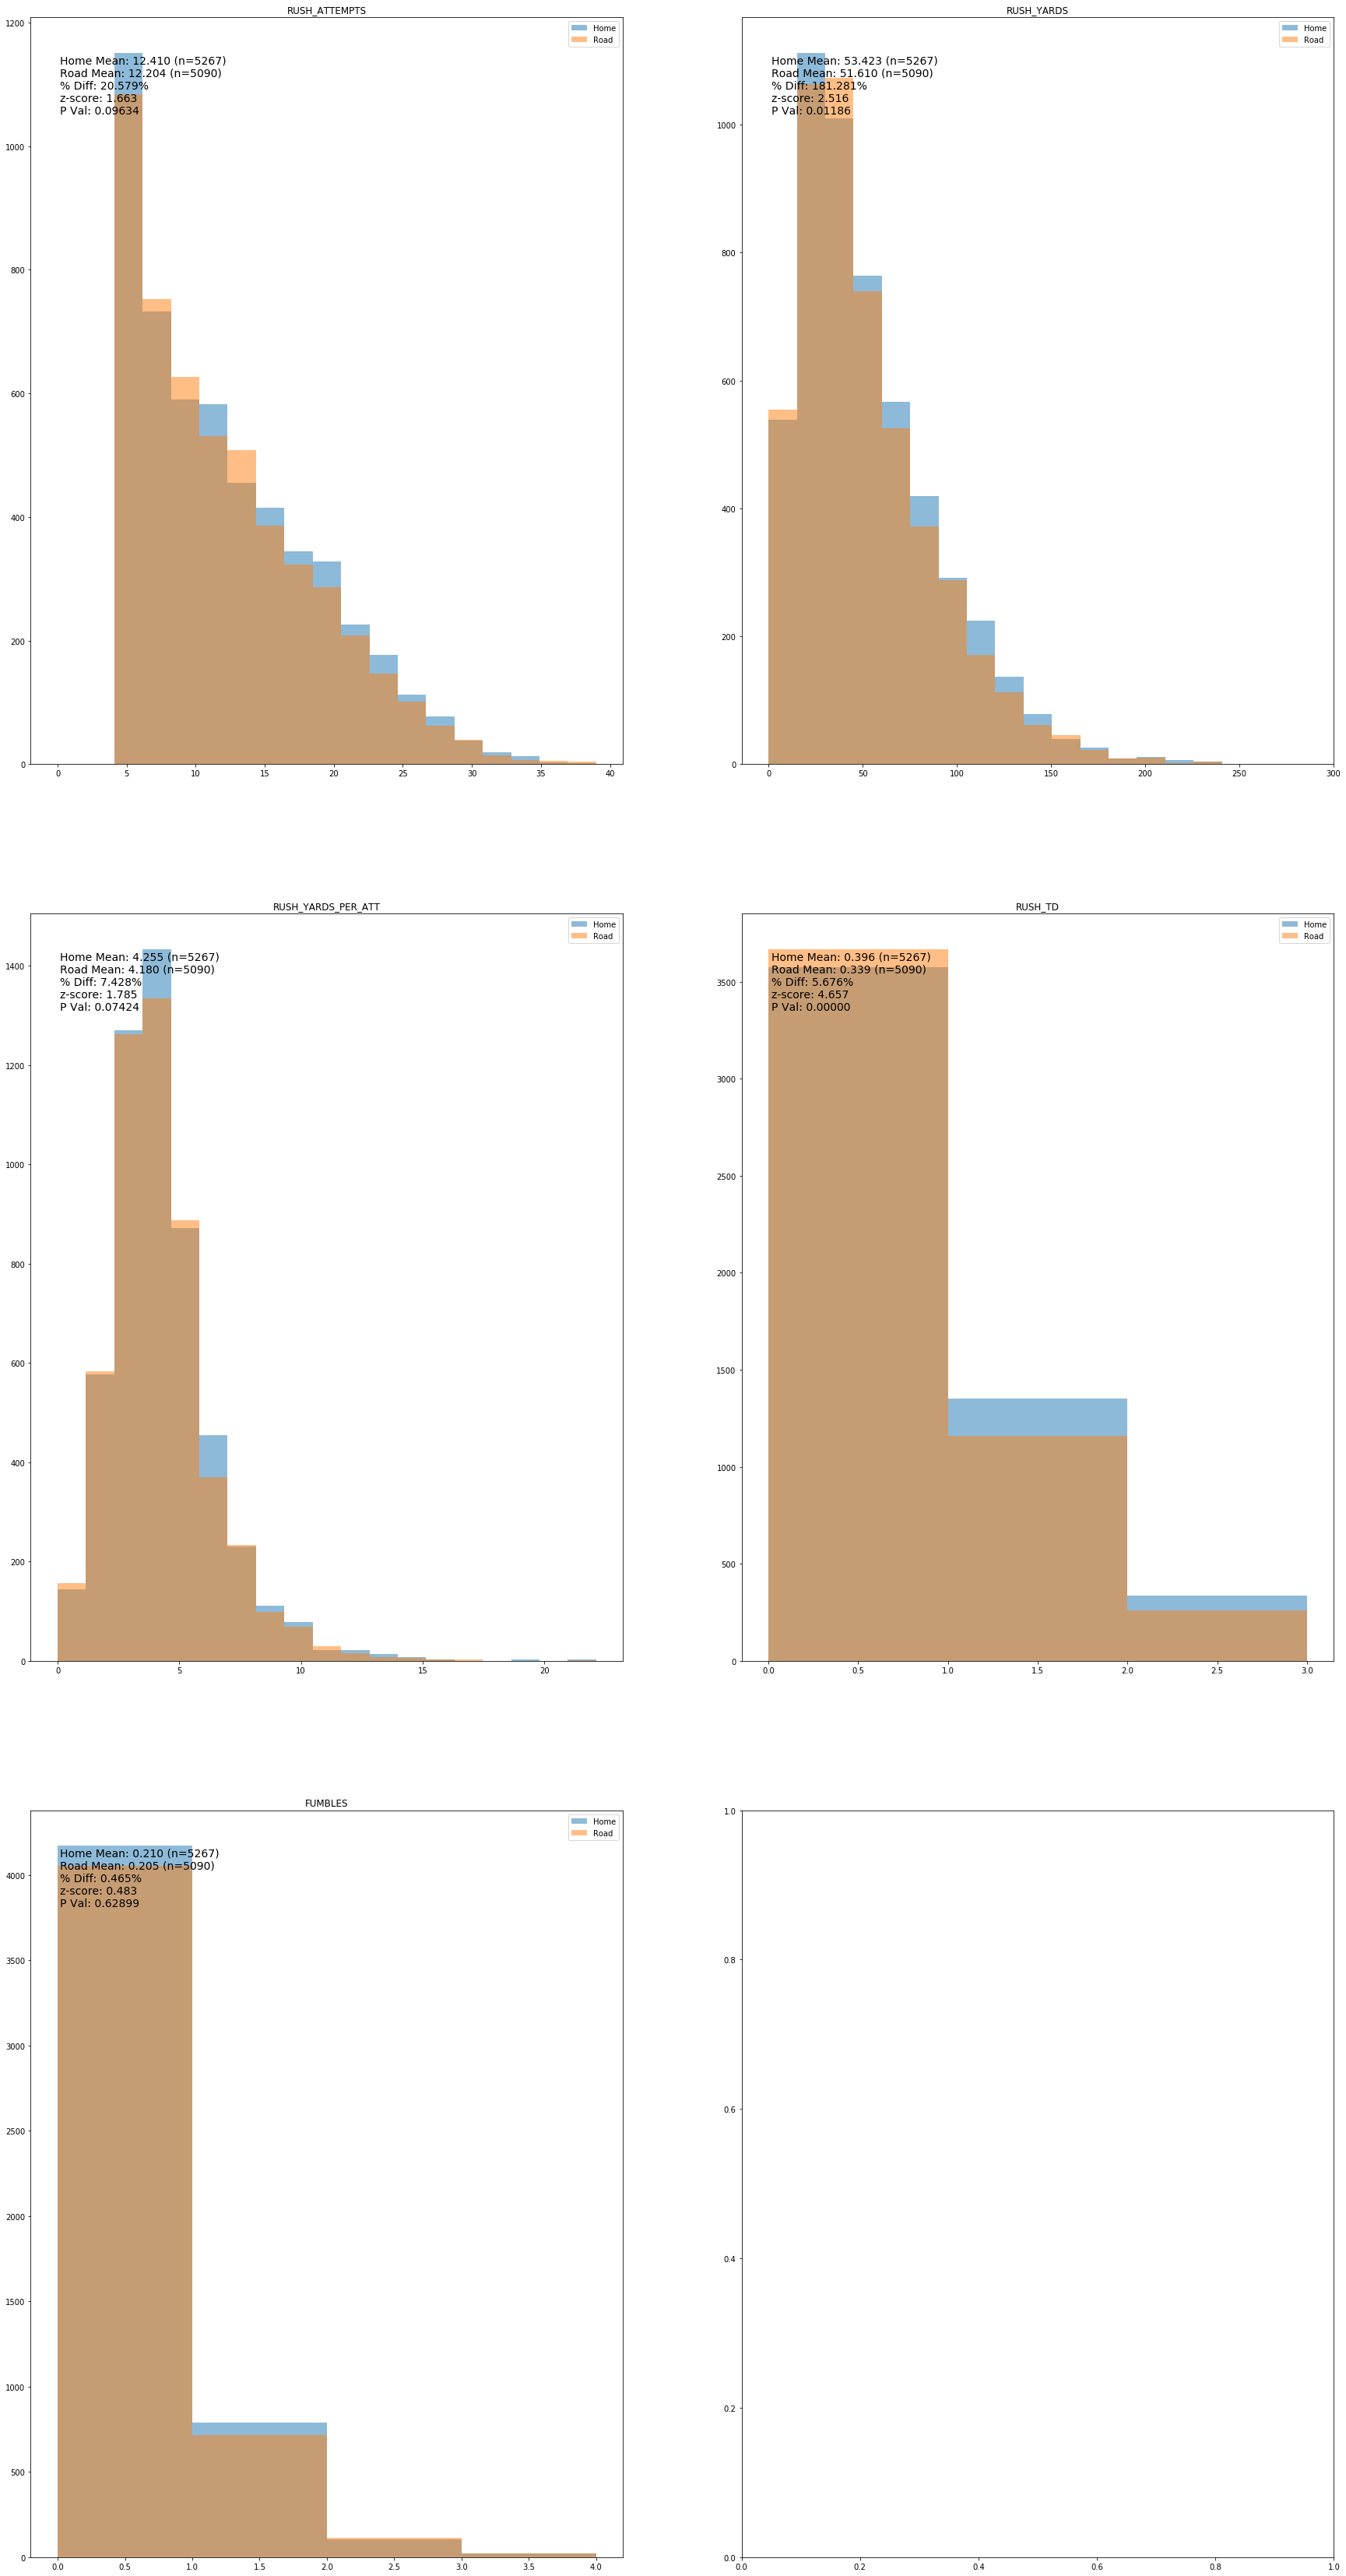

In [86]:
dt = 'rushing'
kvd = get_key_value_dict(dt)
hg = get_home_games(kvd.copy(), dt)
rg = get_road_games(kvd.copy(), dt)
rushing_stat_dict = get_stat_dict(hg, rg, get_stat_ids(dt))
OVERALL_STAT_DICT.update(stat_dict)
plot_stats(hg, rg, dt)

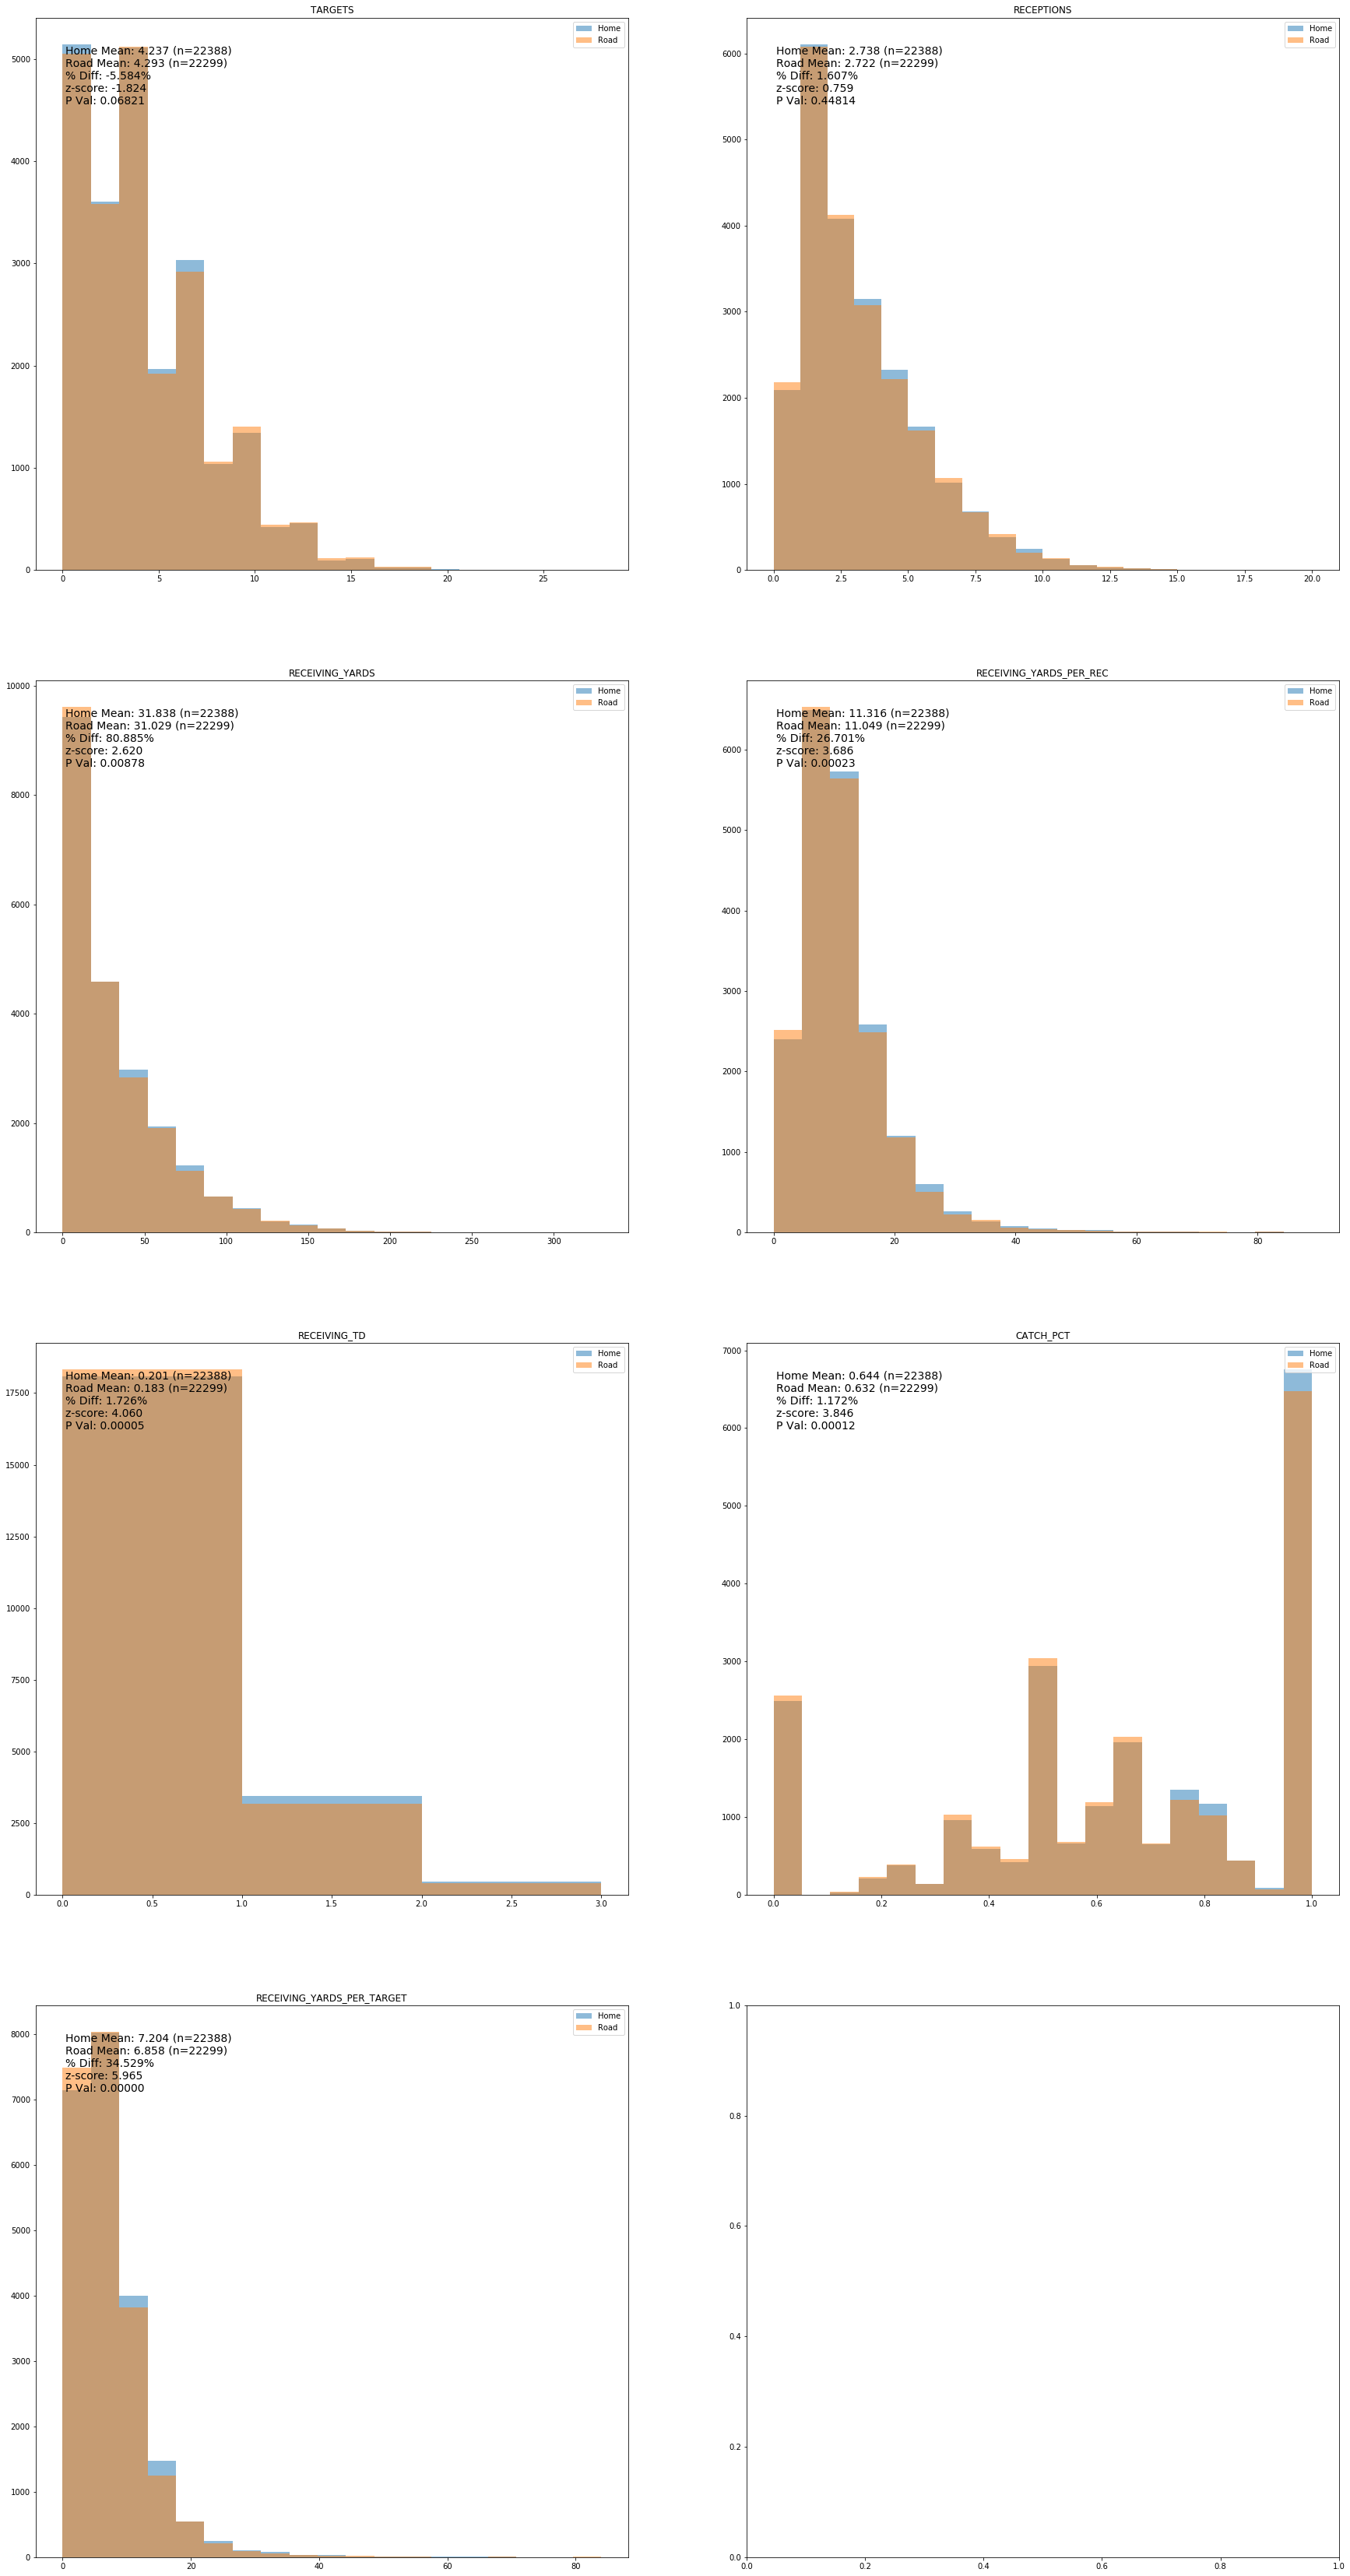

In [87]:
dt = 'receiving'
kvd = get_key_value_dict(dt)
hg = get_home_games(kvd.copy(), dt)
rg = get_road_games(kvd.copy(), dt)
receiving_stat_dict = get_stat_dict(hg, rg, get_stat_ids(dt))
plot_stats(hg, rg, dt)

In [88]:
write_all_aggregated_stats()

In [89]:
full_stat_list = []
list_order = ['home_mean', 'road_mean', 'home_std', 'road_std', 'home_count', 'road_count', 
              'z_score', 'p_val', 'difference', 'pct_difference', 'stat_type']
columns = ['stat_id'] + list_order[:]
for p in passing_stat_dict:
    row = [p]
    for s in passing_stat_dict[p]:
        row.append(passing_stat_dict[p][s])
    full_stat_list.append(row)
for r in rushing_stat_dict:
    row = [r]
    for s in rushing_stat_dict[r]:
        row.append(rushing_stat_dict[r][s])
    full_stat_list.append(row)
for r in receiving_stat_dict:
    row = [r]
    for s in receiving_stat_dict[r]:
        row.append(receiving_stat_dict[r][s])
    full_stat_list.append(row)

df = pd.DataFrame(data=full_stat_list, columns=columns)
df.sort_values(by=['p_val'], inplace=True)
df.to_csv(os.path.join(DATA_DIR, 'processed', 'aggregate', 'aggregate_stats.csv'))